In [1]:
#ipython magic
#%reset -f
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
#general imports
import sys
sys.path.append('..')
sys.path.append('/home/jamesrowland/Documents/Code/Vape/utils')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [3]:
#global plotting params
sns.set()
sns.set_style('white')
sns.set_palette('muted')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [4]:
#notebook specific imports
import utils.utils_funcs as utils
from utils.paq2py import paq_read

In [5]:
s2p_path = '/home/jamesrowland/Documents/packerstation/'\
           'sarmstrong/Data/2019-05-15/RL042/2019-05-15_RL042_B2_t-005/suite2p'

In [6]:
paq_path = '/home/jamesrowland/Documents/packerstation/'\
           'sarmstrong/Data/2019-05-15/RL042/2019-05-15_RL042_B2_t005.paq'

In [7]:
# can only think how to do one plane at a time for now
plane = 0
tot_planes = 3 # how many planes did you record in total?
fs = 15 # total frame rate Hz
fs = fs / tot_planes

In [8]:
# just sticking with plane0 for now
_, spks, stat = utils.s2p_loader(os.path.join(s2p_path, 'plane{}'.format(plane)))
spks.shape

Loading 1088 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7


(1088, 5570)

In [9]:
tot_frames = spks.shape[1] * tot_planes
tot_frames

16710

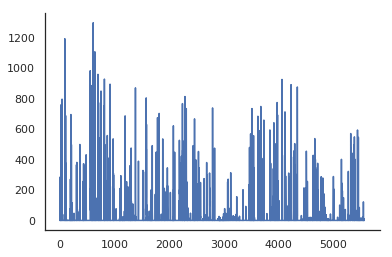

In [10]:
# oasis gives out some weird value that we're not quite sure the meaning of
# it's something like: P(spike in this frame) but why the range is 0-1200
# I have no idea. Adam thinks we should try just putting these values in 
# first. Can try normalising or thresholding later
plt.plot(spks[0,:])
sns.despine()

In [11]:
paq = paq_read(paq_path)
paq['chan_names']

['frame_clock', 'camera_frame', 'piezo_stim']

In [12]:
stim_start = utils.paq_data(paq, 'piezo_stim', threshold_ttl = True)
len(stim_start)

100

In [13]:
frame_clock = utils.paq_data(paq, 'frame_clock', threshold_ttl = True)
frame_clock = frame_clock[:tot_frames] # get rid of foxy bonus frames
frame_clock = frame_clock[plane::tot_planes] # just take clocks from the frame you care about

In [25]:
# set the time window for each trial here. The authors of the paper take 1 second of data 
# per trial. As our stim is longer i'm gonna take 1 second before and after 2 seconds after
# stim onset. Worth playing with this parameter

pre_seconds = 1
post_seconds = 2
pre_frames = int(pre_seconds * fs) # number of frames before stim onset to inlcude in the trial
post_frames = int(post_seconds * fs) # number of frames after stim onset to inlcude in the trial
spks_trials = utils.flu_splitter(spks, frame_clock, stim_start, pre_frames, post_frames)
spks_trials.shape

(1088, 15, 100)

In [20]:
pre_frames

5

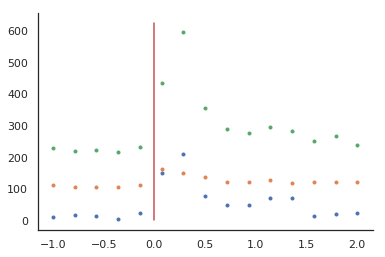

In [50]:
# have plotted this as scatter to show that t=0 occurs between two frames
axes = plt.gca()
x_axis = np.linspace(-pre_seconds, post_seconds, spks_trials.shape[1]) 
for i in range(3):
    meaned = np.mean(spks_trials[i,:,:],1) + i*100
    plt.plot(x_axis, meaned, '.')
sns.despine()
plt.plot(np.zeros(10), np.linspace(0, axes.get_ylim()[1],10))

In [63]:
# trial average each cell
mean_trial = np.mean(spks_trials, 2)
# reshape for subtraction
mean_trial = mean_trial.reshape(spks_trials.shape[0], spks_trials.shape[1], 1)
mean_trial.shape

(1088, 15, 1)

In [66]:
# subtract trial average from each trial
subbed = spks_trials - mean_trial
assert subbed.shape == spks_trials.shape